# ProbeRequest-IE Fingerprinting

### Load libraries

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from scapy.all import PcapReader, Dot11Elt
import pandas as pd

# My library
from analyzer import ProbeRequestAnalyzer, BitAnalyzer

### Fill analyzer with IE bits

In [2]:
FILENAME = "./pcaps/rand_10000.pcap"
NUM_SAMPLES = 69700 # Only used for progress bar

analyzer = ProbeRequestAnalyzer(filename=FILENAME, num_samples=NUM_SAMPLES)
analyzer.extract_information_elements()

Analyzing packets:   0%|          | 0/69700 [00:00<?, ?frames/s]

Analyzing packets:  14%|█▍        | 9967/69700 [00:22<02:16, 436.74frames/s]

Loaded and analyzed packets from ./pcaps/rand_10000.pcap with 22 unique MAC addresses


### Visualize the Information Elements stability and suitability for fingerprinting

Heatmap showing the stability of each bit in the IEs.
A stable bit is one that is the same across all packets sent by the same device.
(Higher values indicate more stable bits)


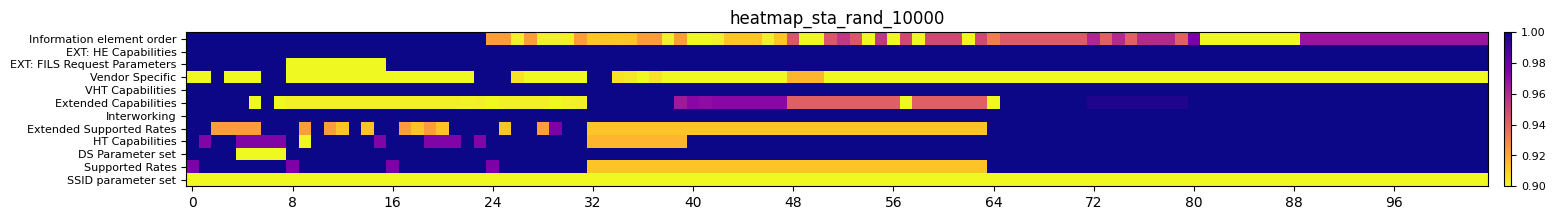

Heatmap showing the suitability of each bit in the IEs.
Suitability also includes variability. A variable bit is one that changes when sent from different devices.
(Higher values indicate stable and variable bits)


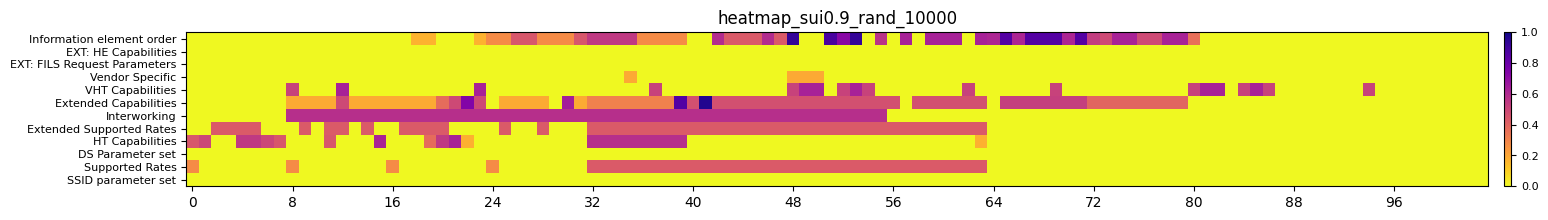

In [3]:
%matplotlib inline
print("Heatmap showing the stability of each bit in the IEs.")
print("A stable bit is one that is the same across all packets sent by the same device.")
print("(Higher values indicate more stable bits)")
analyzer.render_stability_heatmap()

print("Heatmap showing the suitability of each bit in the IEs.")
print("Suitability also includes variability. A variable bit is one that changes when sent from different devices.")
print("(Higher values indicate stable and variable bits)")
analyzer.render_suitability_heatmaps(stability_thresholds=[0.9])

## Experimenting with ProbeRequest-IE Fingerprinting

### Experiment 1: Fingerprint uniqueness
This experiment creates a fingerprint for each probe request based on previous created IE fingerpring masks. 
It then calculates how many different fingerprints were calculated for each device.
And it calculates how many devices share the same fingerprint.

In [4]:
def plot_experiment_results(total_devices, unique_identifiers, stable_devices, unique_identifiers_count,
            stability_threshold, suitability_threshold, filename=None):
    """Generate a simple bar chart for experiment results."""
    metrics = ['Total Devices', 'Unique Identifiers', 'Devices with only 1 identifier', 'Identifiers with only 1 device']
    values = [total_devices, unique_identifiers, stable_devices, unique_identifiers_count]
    percentages = [100, (unique_identifiers / total_devices) * 100, (stable_devices / total_devices) * 100, (unique_identifiers_count / unique_identifiers) * 100]
    
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, percentages, color=['blue', 'green', 'orange', 'red'])
    plt.title(f"Identification Experiment Results\n"
        f"Stability Threshold={stability_threshold}, Suitability Threshold={suitability_threshold}")
    plt.xlabel("Metrics")
    plt.ylabel("Percentages (%)")
    
    # Display percentages on top of bars
    for i, v in enumerate(percentages):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')
    
    plt.tight_layout()

    # Save the plot
    base_filename = filename.split('/')[-1].split('.')[0]
    plt.savefig(f"./outputs/fingerprint_{base_filename}_sta{stability_threshold}_sui{suitability_threshold}.png")

def experiment_with_identification(analyzer: ProbeRequestAnalyzer, stability_threshold: float = 0.95, suitability_threshold: float = 0.9):
    """Run experiment with detailed analysis of identification patterns."""
    print(f"\nRunning detailed identification experiment with stability={stability_threshold}, suitability={suitability_threshold}")
    
    # Calculate suitability and create masks
    suitability_data = analyzer.bit_analyzer.calculate_suitability(stability_threshold)
    masks = analyzer.bit_analyzer.create_masks(suitability_data, suitability_threshold)

    # print mask so that it can be copied and used in another script
    # print(masks)
    
    # Data structures for analysis
    mac_to_identifier_counts = defaultdict(lambda: defaultdict(int))  # MAC -> {identifier: count}
    identifier_to_mac_counts = defaultdict(lambda: defaultdict(int))  # identifier -> {MAC: count}
    total_packets_per_mac = defaultdict(int)  # MAC -> total_packets
    
    # Process packets
    with PcapReader(analyzer.filename) as pcap_reader:
        for packet in tqdm(pcap_reader, desc="Testing identification", unit="frames", total=analyzer.num_samples):
            if not packet.haslayer(Dot11Elt):
                continue
                
            mac_addr = packet.addr2
            if mac_addr is None:
                continue
                
            # Generate IDs for probe requests
            identifier = analyzer.bit_analyzer.get_id(packet, masks)
            mac_to_identifier_counts[mac_addr][identifier] += 1
            identifier_to_mac_counts[identifier][mac_addr] += 1
            total_packets_per_mac[mac_addr] += 1
    
    # Create analysis tables
    mac_analysis = []
    for mac, id_counts in mac_to_identifier_counts.items():
        mac_short = mac[-5:]  # Last two hex values
        total_packets = total_packets_per_mac[mac]
        for identifier, count in id_counts.items():
            percentage = (count / total_packets) * 100
            mac_analysis.append({
                'MAC': mac_short,
                'Identifier': identifier,
                'Occurrences': count,
                'Total_Packets': total_packets,
                'Percentage': f'{percentage:.1f}%'
            })
    
    identifier_analysis = []
    for idx, (identifier, mac_counts) in enumerate(identifier_to_mac_counts.items()):
        total_occurrences = sum(mac_counts.values())
        for mac, count in mac_counts.items():
            mac_short = mac[-5:]
            percentage = (count / total_occurrences) * 100
            identifier_analysis.append({
                'Identifier': identifier,
                'MAC': mac_short,
                'Occurrences': count,
                'Total_Occurrences': total_occurrences,
                'Percentage': f'{percentage:.1f}%'
            })
    
    # Convert to DataFrames for better display
    mac_df = pd.DataFrame(mac_analysis)
    identifier_df = pd.DataFrame(identifier_analysis)
    
    # Filter out rare cases that appear less than 10% of the time (sorry for the ugly code)
    rarity_threshold = 0.1
    total_devices = len(mac_to_identifier_counts)
    significant_identifiers = {id for id, mac_counts in identifier_to_mac_counts.items() 
                                if any(count/total_packets_per_mac[mac] >= rarity_threshold for mac, count in mac_counts.items())}
    unique_identifiers = len(significant_identifiers)
    stable_devices = sum(1 for mac, id_counts in mac_to_identifier_counts.items() 
                        if max(id_counts.values()) / total_packets_per_mac[mac] >= 1-rarity_threshold)
    unique_identifiers_count = sum(1 for id, mac_counts in identifier_to_mac_counts.items() 
                                    if len(mac_counts) == 1 and next(iter(mac_counts.values())) / total_packets_per_mac[next(iter(mac_counts.keys()))] >= rarity_threshold)
    
    # Calculate summary statistics
    stable_devices_percentage = stable_devices / total_devices
    unique_identifiers_percentage = unique_identifiers_count / unique_identifiers

    # Print summary statistics
    print("\n=== Summary Statistics ===")
    print(f"📱 Total devices: {total_devices}")
    print(f"🔑 Unique identifiers generated: {unique_identifiers}")
    print(f"🙂 Devices with stable identifier: {stable_devices} ({stable_devices_percentage:.2%})")
    print(f"😥 Devices with multiple identifiers: {total_devices - stable_devices} ({1 - stable_devices_percentage:.2%})")
    print(f"🙂 Identifiers matching unique device: {unique_identifiers_count} ({unique_identifiers_percentage:.2%})")
    print(f"😥 Identifiers matching multiple devices: {unique_identifiers - unique_identifiers_count} ({1 - unique_identifiers_percentage:.2%})")
    
    print("\n=== MAC Address Analysis ===")
    print("Shows how many times each identifier was seen for each MAC address:")
    print(mac_df.to_string(index=False))
    
    print("\n=== Identifier Analysis ===")
    print("Shows how many times each MAC address was seen for each identifier:")
    print(identifier_df.to_string(index=False))
    
    # Plot results
    plot_experiment_results(
        total_devices, unique_identifiers, stable_devices, unique_identifiers_count,
        stability_threshold, suitability_threshold, analyzer.filename
    )
    
    return mac_to_identifier_counts, identifier_to_mac_counts

### Start the experiment


Running experiment with stability=0.85, suitability=0.4

Running detailed identification experiment with stability=0.85, suitability=0.4


Testing identification: 100%|██████████| 9967/9967 [00:26<00:00, 379.75frames/s]



=== Summary Statistics ===
📱 Total devices: 22
🔑 Unique identifiers generated: 25
🙂 Devices with stable identifier: 17 (77.27%)
😥 Devices with multiple identifiers: 5 (22.73%)
🙂 Identifiers matching unique device: 22 (88.00%)
😥 Identifiers matching multiple devices: 3 (12.00%)

=== MAC Address Analysis ===
Shows how many times each identifier was seen for each MAC address:
  MAC Identifier  Occurrences  Total_Packets Percentage
00:00   50263d64          198            198     100.0%
00:01   798a9b3a           73             77      94.8%
00:01   1c4f310f            4             77       5.2%
00:02   6b660da3            5            813       0.6%
00:02   192f556d           57            813       7.0%
00:02   5214cfc4          751            813      92.4%
00:03   4e85816a           64             67      95.5%
00:03   fbd86f0f            3             67       4.5%
00:04   a19c9502         2005           2005     100.0%
00:05   eff09327           10             16      62.5%
00:05  

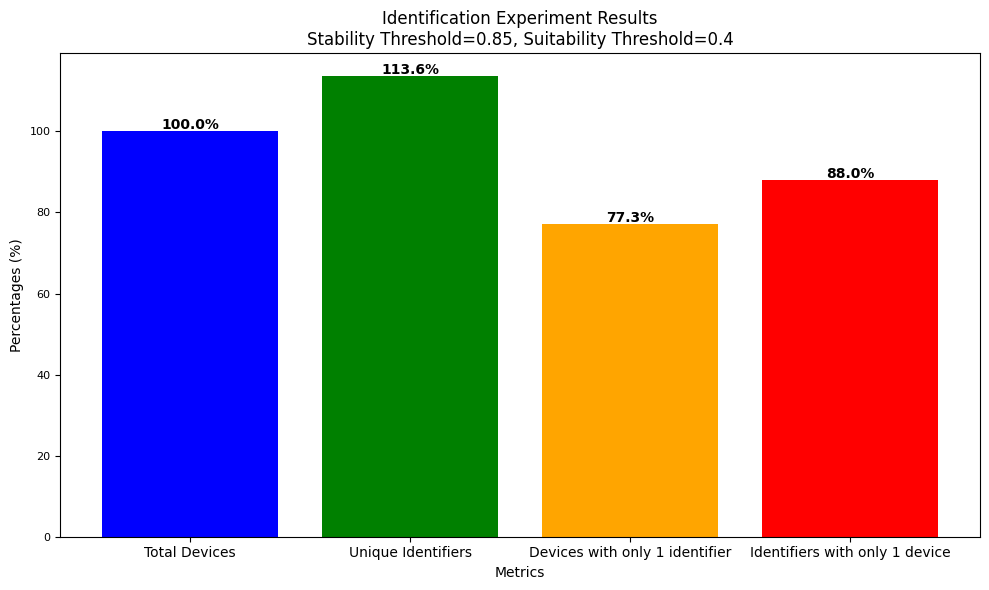

In [5]:
EXPERIMENT_STABILITY_THRESHOLDS = [0.85]
EXPERIMENT_SUITABILITY_THRESHOLDS = [0.4]

# Run identification experiments with different thresholds
for stability in EXPERIMENT_STABILITY_THRESHOLDS:
    for suitability in EXPERIMENT_SUITABILITY_THRESHOLDS:
        print(f"\nRunning experiment with stability={stability}, suitability={suitability}")
        experiment_with_identification(
            stability_threshold=stability,
            suitability_threshold=suitability,
            analyzer=analyzer,
        )